In [34]:
import pandas as pd
import acquire
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [35]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# import env

## Acquire

OWL - Overwatch League

In [36]:
df = acquire.get_map_data()
df

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,team_one_name,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,Los Angeles Valiant,San Francisco Shock,75.615051,0.000000,0.000000,240.000000,NaN,NaN,2,0
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,Los Angeles Valiant,San Francisco Shock,75.649597,75.615051,125.750572,0.000000,NaN,NaN,3,2
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,250.492004,240.000000,NaN,NaN,2,0
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,225.789032,250.492004,NaN,NaN,2,2
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,36.396057,250.492004,NaN,NaN,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11231,2021-09-26 01:57:42,2021-09-26 02:04:09,OWL 2021,37441,3,Shanghai Dragons,Shanghai Dragons,Atlanta Reign,King's Row,2,...,Atlanta Reign,Shanghai Dragons,70.287613,70.287613,93.260010,196.845001,NaN,NaN,3,3
11232,2021-09-26 02:05:35,2021-09-26 02:08:24,OWL 2021,37441,3,Shanghai Dragons,Shanghai Dragons,Atlanta Reign,King's Row,3,...,Atlanta Reign,Shanghai Dragons,9.008842,70.287613,0.000000,196.845001,NaN,NaN,5,3
11233,2021-09-26 02:09:50,2021-09-26 02:12:41,OWL 2021,37441,3,Shanghai Dragons,Shanghai Dragons,Atlanta Reign,King's Row,4,...,Atlanta Reign,Shanghai Dragons,9.014740,9.008842,25.285004,0.000000,NaN,NaN,6,5
11234,2021-09-26 02:53:59,2021-09-26 03:01:59,OWL 2021,37441,4,Shanghai Dragons,Shanghai Dragons,Atlanta Reign,Havana,1,...,Shanghai Dragons,Atlanta Reign,55.211487,0.000000,0.000000,0.000000,NaN,NaN,2,0


I have pulled the information from this website <a href="https://overwatchleague.com/en-us/statslab">this website.</a>

Additional information for accurate predictions can be found using this website. For the time being an dkeeping an MVP model in mind we are sticking with this one dataset first

## Prepare

In order to make this more freindly for my level I am going to drop off the round end time since I only need one time for the index. First I need to check if there is ever any overlap in time.

In [37]:
#this code checks if there were any times where there are ducplicates 
df[df.round_start_time == df.round_end_time]
#since there is not I can comfortably set the index to round start time

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,team_one_name,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score


In [38]:
#chopping off round end time 
df = df.drop(columns="round_end_time")
df.head(3)
#now I can render the round start as a pandas time object as well as setting it to my index for further questioning

,round_start_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,winning_team_final_map_score,...,team_one_name,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score
0,2018-01-11 00:12:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,3,...,Los Angeles Valiant,San Francisco Shock,75.615051,0.000000,0.000000,240.0,NaN,NaN,2,0
1,2018-01-11 00:22:05,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,3,...,Los Angeles Valiant,San Francisco Shock,75.649597,75.615051,125.750572,0.0,NaN,NaN,3,2
2,2018-01-11 00:34:39,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,4,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,250.492004,240.0,NaN,NaN,2,0


I am reminded that before I get any further into this (ie: exploratory data analysis) I need to adequatly split my dataframe into train validate test sets.

Before I get too far ahead of myself I must apply the changes mentioned above.

In [39]:
df.round_start_time = pd.to_datetime(df.round_start_time)
df.dtypes
#now i need to index this

round_start_time                datetime64[ns]
stage                                   object
match_id                                 int64
game_number                              int64
match_winner                            object
map_winner                              object
map_loser                               object
map_name                                object
map_round                                int64
winning_team_final_map_score             int64
losing_team_final_map_score              int64
control_round_name                      object
attacker                                object
defender                                object
team_one_name                           object
team_two_name                           object
attacker_payload_distance              float64
defender_payload_distance              float64
attacker_time_banked                   float64
defender_time_banked                   float64
attacker_control_perecent              float64
defender_cont

In [40]:
"""
while this code does not provide anything haptically meaningful to use I would 
like to use this to see later down the line if there are trends in performance based off of the day
"""
df['weekday'] = df.round_start_time.dt.day_name()
df.head(3)

,round_start_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,winning_team_final_map_score,...,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,weekday
0,2018-01-11 00:12:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,3,...,San Francisco Shock,75.615051,0.000000,0.000000,240.0,NaN,NaN,2,0,Thursday
1,2018-01-11 00:22:05,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,3,...,San Francisco Shock,75.649597,75.615051,125.750572,0.0,NaN,NaN,3,2,Thursday
2,2018-01-11 00:34:39,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,4,...,San Francisco Shock,0.000000,0.000000,250.492004,240.0,NaN,NaN,2,0,Thursday


In [41]:
#now that this is in the index format I can use my knowledge of time based EDA
f = df.set_index('round_start_time').sort_index()
df.head(3)
#problem here is that we as data scientists do exploration on the train dataset

,round_start_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,winning_team_final_map_score,...,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,weekday
0,2018-01-11 00:12:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,3,...,San Francisco Shock,75.615051,0.000000,0.000000,240.0,NaN,NaN,2,0,Thursday
1,2018-01-11 00:22:05,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,3,...,San Francisco Shock,75.649597,75.615051,125.750572,0.0,NaN,NaN,3,2,Thursday
2,2018-01-11 00:34:39,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,4,...,San Francisco Shock,0.000000,0.000000,250.492004,240.0,NaN,NaN,2,0,Thursday


In [42]:
#this tells us what the range of time is
df.index.min(), df.index.max()

(0, 11235)

This dataset contains about 3 years and 7 months worth of data initially. The problem with this assumption is that games are not played everyday of the week.

In [43]:
df.index.min() - df.index.max()

-11235

"We explore on train" -Ryan Orsinger

In [44]:
train_size = int(len(df) * .5)
#this splits half of the data into a train set

validate_size = int(len(df) * .3)
#about a third of this dataset is reserved for validation

test_size = int(len(df) - train_size - validate_size)
#the remainder of the data will be saved to proof the models with

validate_end_index = train_size + validate_size
#giving the above a variable to model with

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

I have successfully completed the data split here, I now can go on to exploration.

## Explore

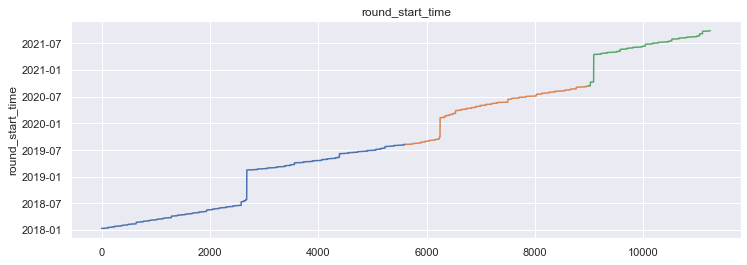

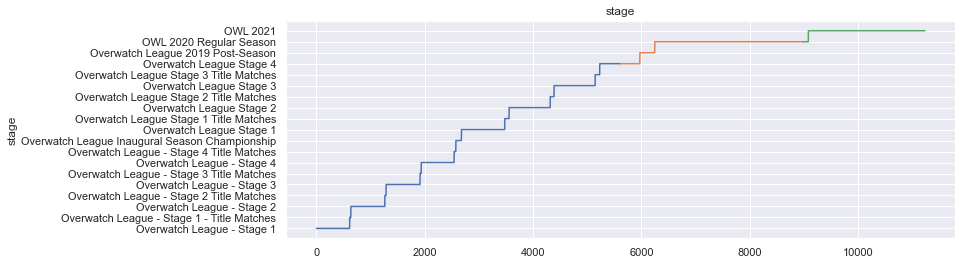

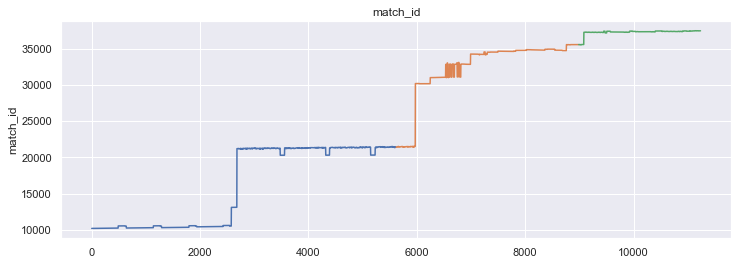

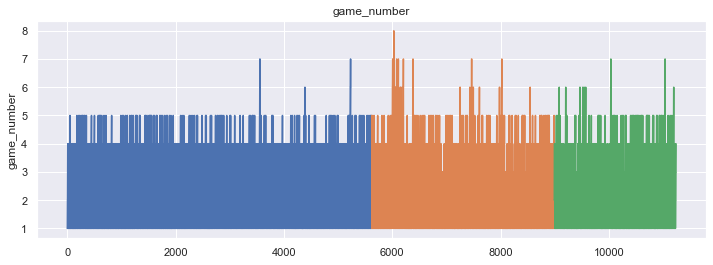

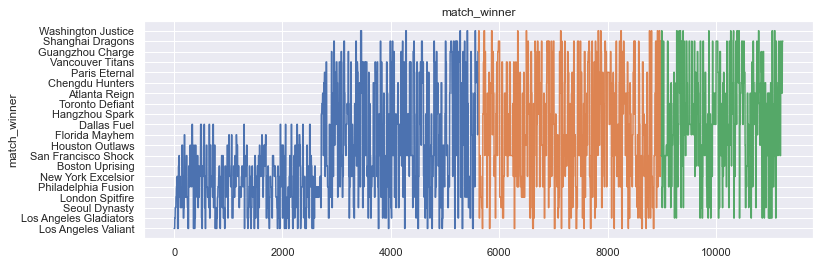

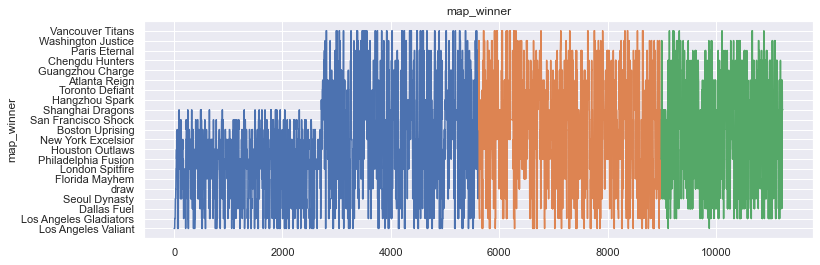

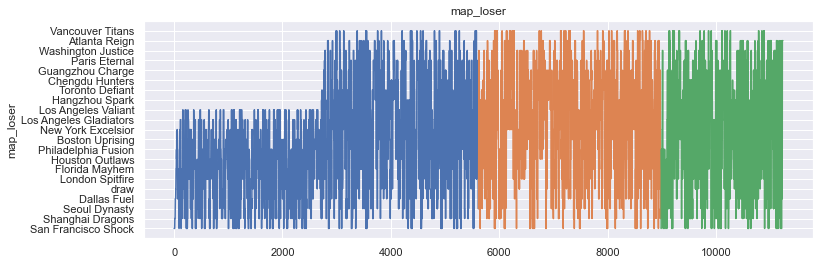

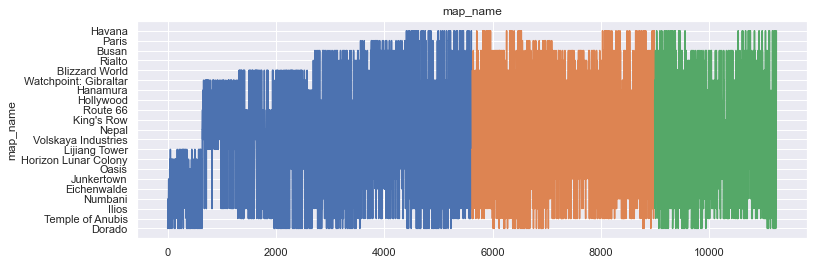

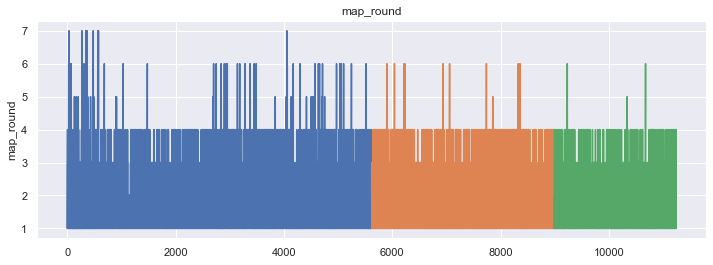

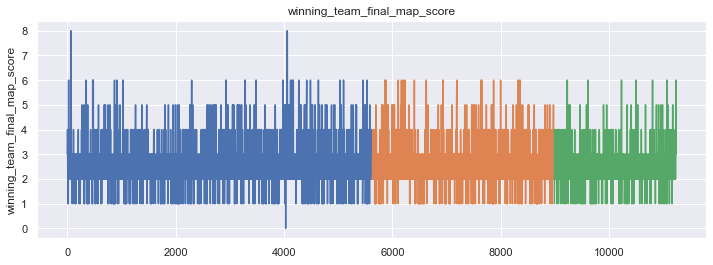

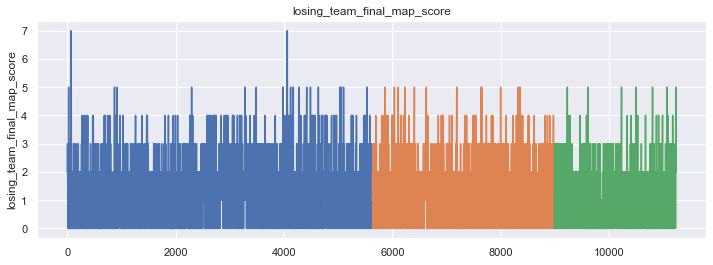

ValueError: could not convert string to float: 'Lighthouse'

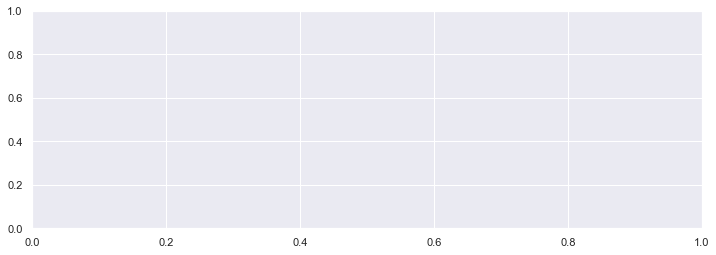

In [45]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()
    #this is bizarre the first time I ran this function the graphs look different

Takeaway(graph by graph):
<hr>

__Seasonality here is clear as day__ (which means there are reapeating chunks)
- Overwatch Stage naming conventions changes over time, after the mid point of 2019 the stages got dropped of and are now just "OWL"
- The match_ids are used to reference when the games were played (categorical tags)
- There are spikes in game_numbers at the end of spikes, suggesting finals have more games played
- Match_winner suggests that OWL had half of the current roster in 2018
    - it wasn't until 2019 where the rest of the leagues came together
- In map_winner there are patterns but they are hard to make out
    - This illudes to the next step being to zoom in on these time chunks
        - Small gaps in the data suggest that thesegames are split by weeks and months
            - LA Gladiators didn't do too hot in the first season
- map_loser is the inverse
- map_name tells us that not all maps are in constant rotation
- map_round  show us that there are less and less games played over the existance of the league
- winning_team_final_map_score says that the majority of the  victories are in the 1-4 point range
    - many of the games go to 6 points
        - there are 2 outliers


Grand Summary: These chunks of activity hold more of what we are looking for so the next step would be to zoom into all of these chunks.

In [ ]:
#now to the ciriculumn to find how to zoom into the data

In [46]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [47]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


In [48]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


From here in I will be using the one zoomed in area to study from. Each one of these seasons are equal and worthy of being studied. The porblem is that it does not lend it self to the MVP model. To keep things easy I will zoom into the first season.

To do this I will be using techniques that Ryan McCall has taught in his lecture at CodeUp.

In [49]:
df

,round_start_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,winning_team_final_map_score,...,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,weekday
0,2018-01-11 00:12:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,3,...,San Francisco Shock,75.615051,0.000000,0.000000,240.000000,NaN,NaN,2,0,Thursday
1,2018-01-11 00:22:05,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,3,...,San Francisco Shock,75.649597,75.615051,125.750572,0.000000,NaN,NaN,3,2,Thursday
2,2018-01-11 00:34:39,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,4,...,San Francisco Shock,0.000000,0.000000,250.492004,240.000000,NaN,NaN,2,0,Thursday
3,2018-01-11 00:40:27,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,4,...,San Francisco Shock,0.000000,0.000000,225.789032,250.492004,NaN,NaN,2,2,Thursday
4,2018-01-11 00:46:09,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,4,...,San Francisco Shock,0.000000,0.000000,36.396057,250.492004,NaN,NaN,4,2,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11231,2021-09-26 01:57:42,OWL 2021,37441,3,Shanghai Dragons,Shanghai Dragons,Atlanta Reign,King's Row,2,6,...,Shanghai Dragons,70.287613,70.287613,93.260010,196.845001,NaN,NaN,3,3,Sunday
11232,2021-09-26 02:05:35,OWL 2021,37441,3,Shanghai Dragons,Shanghai Dragons,Atlanta Reign,King's Row,3,6,...,Shanghai Dragons,9.008842,70.287613,0.000000,196.845001,NaN,NaN,5,3,Sunday
11233,2021-09-26 02:09:50,OWL 2021,37441,3,Shanghai Dragons,Shanghai Dragons,Atlanta Reign,King's Row,4,6,...,Shanghai Dragons,9.014740,9.008842,25.285004,0.000000,NaN,NaN,6,5,Sunday
11234,2021-09-26 02:53:59,OWL 2021,37441,4,Shanghai Dragons,Shanghai Dragons,Atlanta Reign,Havana,1,3,...,Atlanta Reign,55.211487,0.000000,0.000000,0.000000,NaN,NaN,2,0,Sunday


In [50]:
y = train.match_winner.value_counts()
y
#hold on it needs a numbers

New York Excelsior        604
Philadelphia Fusion       472
London Spitfire           462
San Francisco Shock       442
Los Angeles Valiant       433
Los Angeles Gladiators    420
Boston Uprising           400
Seoul Dynasty             388
Houston Outlaws           315
Vancouver Titans          305
Dallas Fuel               242
Shanghai Dragons          184
Hangzhou Spark            171
Guangzhou Charge          147
Chengdu Hunters           141
Atlanta Reign             130
Florida Mayhem            109
Paris Eternal             101
Toronto Defiant            92
Washington Justice         60
Name: match_winner, dtype: int64

<AxesSubplot:ylabel='Frequency'>

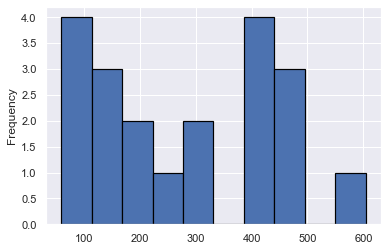

In [51]:
y.plot.hist(linewidth=1.2, edgecolor='black')

In [52]:
df = df.replace(' ', '_', regex=True)
df.head(3)

,round_start_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,winning_team_final_map_score,...,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,weekday
0,2018-01-11 00:12:07,Overwatch_League_-_Stage_1,10223,1,Los_Angeles_Valiant,Los_Angeles_Valiant,San_Francisco_Shock,Dorado,1,3,...,San_Francisco_Shock,75.615051,0.000000,0.000000,240.0,NaN,NaN,2,0,Thursday
1,2018-01-11 00:22:05,Overwatch_League_-_Stage_1,10223,1,Los_Angeles_Valiant,Los_Angeles_Valiant,San_Francisco_Shock,Dorado,2,3,...,San_Francisco_Shock,75.649597,75.615051,125.750572,0.0,NaN,NaN,3,2,Thursday
2,2018-01-11 00:34:39,Overwatch_League_-_Stage_1,10223,2,Los_Angeles_Valiant,Los_Angeles_Valiant,San_Francisco_Shock,Temple_of_Anubis,1,4,...,San_Francisco_Shock,0.000000,0.000000,250.492004,240.0,NaN,NaN,2,0,Thursday


In [57]:
df[df.eq("NoneType").any(1)]

,round_start_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,winning_team_final_map_score,...,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score,weekday


In [58]:
sns.catplot(y=train.match_winner.value_counts(), x=train.match_winner)
# TypeError: object of type 'NoneType' has no len()
# df[df.eq("NoneType").any(1)] I used this code to find where this 'NoneType' value is
# I am running into a wall of losing energy
#I am not entirely sure I can slide this one in on time

TypeError: object of type 'NoneType' has no len()

### Hypotheses:
<hr>

- The map will be the best measure of a team's success rate.
- There is some noticably change based off of weekday.
- Some teams perform better agaisnt other teams (ie; least amount of wins vs most amount of wins)

Questions:
<hr>

- Are there patterns in the data?
- If there are what sense can we make of them?
- What team has won the most?
    - What team has won the least?
- What metrics would best be used to measure a teams success or loss?
- Are there equal performances based off of objective type?
- Are there different performances between maps per team?
- Are there macro or micro differences based off of the day performed
    - That and the stage it is in. (ie, more loses in good teams at finals)
- Are there teams that have improved over the league?
- Are there teams that peaked?